In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [24]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 11))

In [25]:
rand_sub_bval_indice_100206

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187,
       188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200,
       201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213,
       214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 240, 241, 242,
       243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255,
       256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268,
       269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281,
       282, 283, 284, 285, 286, 287])

In [26]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [27]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [28]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [29]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [30]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

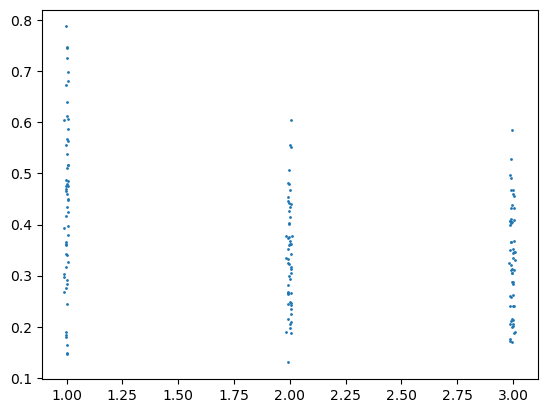

In [31]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [21]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [22]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [23]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [32]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [33]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(164, 3)


In [34]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [35]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [ ]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:55<00:00, 130.67it/s]


Loss: 509.20811741566285
Average Loss: 0.06967817698627023
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.29it/s]


Loss: 433.2214853409678
Average Loss: 0.059280444080592194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.09it/s]


Loss: 431.5047168722376
Average Loss: 0.059045527760295244
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 168.41it/s]


Loss: 430.2567132059485
Average Loss: 0.058874755501634984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 156.53it/s]


Loss: 429.4889017995447
Average Loss: 0.05876969099610628
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.73it/s]


Loss: 428.80521889962256
Average Loss: 0.058676138327808235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.03it/s]


Loss: 428.31019911775365
Average Loss: 0.058608401630781834
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:02<00:00, 116.65it/s]


Loss: 427.8018888218794
Average Loss: 0.05853884630841261
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.81it/s]


Loss: 428.13685832405463
Average Loss: 0.058584682310352305
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:17<00:00, 93.83it/s]


Loss: 427.7489928775467
Average Loss: 0.05853160822079183
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▋                                                                                                                                                           | 122/7308 [00:04<01:09, 103.89it/s]

X_batch: 
torch.Size([128, 164])
tensor([[0.5698, 0.2563, 0.2480,  ..., 0.3560, 0.5122, 0.1675],
        [0.4630, 0.2529, 0.1285,  ..., 0.4485, 0.2670, 0.1127],
        [0.4999, 0.3850, 0.0917,  ..., 0.4869, 0.2056, 0.1881],
        ...,
        [0.7481, 0.4207, 0.1641,  ..., 0.4485, 0.4956, 0.2755],
        [0.6594, 0.1912, 0.2545,  ..., 0.3360, 0.4235, 0.1767],
        [0.4368, 0.2885, 0.1279,  ..., 0.4304, 0.1451, 0.1228]])
X_pred: 
torch.Size([128, 164])
tensor([[0.4946, 0.3052, 0.2119,  ..., 0.4753, 0.3124, 0.2163],
        [0.4394, 0.2173, 0.1171,  ..., 0.4321, 0.2205, 0.1226],
        [0.4839, 0.2658, 0.1563,  ..., 0.4735, 0.2705, 0.1641],
        ...,
        [0.5118, 0.3527, 0.2625,  ..., 0.4868, 0.3656, 0.2759],
        [0.5008, 0.3369, 0.2611,  ..., 0.4767, 0.3427, 0.2581],
        [0.4529, 0.2252, 0.1193,  ..., 0.4464, 0.2279, 0.1245]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.49it/s]


Loss: 427.27777683897875
Average Loss: 0.05846712874096589
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.07it/s]


Loss: 426.49801344424486
Average Loss: 0.05836042876905376
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.52it/s]


Loss: 426.49879000894725
Average Loss: 0.058360535031328306
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.67it/s]


Loss: 426.84670385112986
Average Loss: 0.05840814228942664
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.78it/s]


Loss: 426.38811300043017
Average Loss: 0.05834539039414753
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.54it/s]


Loss: 426.4603943102993
Average Loss: 0.05835528110431025
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.05it/s]


Loss: 426.18054493842646
Average Loss: 0.05831698753946722
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.37it/s]


Loss: 426.0578598170541
Average Loss: 0.0583001997560282
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.34it/s]


Loss: 425.72184436325915
Average Loss: 0.058254220629893154
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.79it/s]


Loss: 426.3306707618758
Average Loss: 0.058337530208247924
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.29it/s]


Loss: 425.45278098550625
Average Loss: 0.05821740298104902
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.48it/s]


Loss: 426.08237658115104
Average Loss: 0.05830355454038739
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.74it/s]


Loss: 425.1482346104458
Average Loss: 0.05817572996858864
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.32it/s]


Loss: 425.7679031342268
Average Loss: 0.05826052314370919
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.96it/s]


Loss: 425.36811670078896
Average Loss: 0.058205817829883544
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.19it/s]


Loss: 425.53644714457914
Average Loss: 0.05822885155235073
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.19it/s]


Loss: 425.062673187349
Average Loss: 0.05816402205628749
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.24it/s]


Loss: 424.61317383730784
Average Loss: 0.05810251420871755
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.44it/s]


Loss: 424.89837022777647
Average Loss: 0.05814153944003509
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.23it/s]


Loss: 424.5127990213223
Average Loss: 0.058088779285895224
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.15it/s]


Loss: 424.9783781785518
Average Loss: 0.05815248743548875
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.02it/s]


Loss: 424.5047580394894
Average Loss: 0.058087678987341185
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.99it/s]


Loss: 424.0638422323391
Average Loss: 0.0580273456803967
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.04it/s]


Loss: 424.166592430789
Average Loss: 0.05804140564187042
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.96it/s]


Loss: 423.95065852371044
Average Loss: 0.05801185803553783
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.11it/s]


Loss: 423.4868834714871
Average Loss: 0.05794839675307705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.65it/s]


Loss: 423.6319894096814
Average Loss: 0.05796825251911349
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.75it/s]


Loss: 423.4749361181166
Average Loss: 0.05794676192092455
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.85it/s]


Loss: 423.48975283885375
Average Loss: 0.05794878938681633
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.64it/s]


Loss: 423.4488755466882
Average Loss: 0.0579431958876147
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.11it/s]


Loss: 423.0159898083657
Average Loss: 0.05788396138592853
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.77it/s]


Loss: 423.36348598240875
Average Loss: 0.05793151149184575
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.76it/s]


Loss: 422.64706902508624
Average Loss: 0.057833479614817496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.75it/s]


Loss: 422.8008034620434
Average Loss: 0.057854516073076546
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.17it/s]


Loss: 422.7603405273985
Average Loss: 0.057848979273043034
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.31it/s]


Loss: 422.8181004729122
Average Loss: 0.05785688293280134
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.01it/s]


Loss: 422.87663844716735
Average Loss: 0.05786489305516795
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 164.64it/s]


Loss: 422.5094276010059
Average Loss: 0.05781464526560015
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.08it/s]


Loss: 422.6347868719604
Average Loss: 0.05783179896989058
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 140.73it/s]


Loss: 422.25949749397114
Average Loss: 0.057780445743564744
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.60it/s]


Loss: 422.6135370740667
Average Loss: 0.05782889122524175
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.43it/s]


Loss: 422.0952659549657
Average Loss: 0.057757972900241615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.63it/s]


Loss: 422.378173250705
Average Loss: 0.05779668490020594
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.31it/s]


Loss: 422.02010691841133
Average Loss: 0.05774768841248103
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.61it/s]


Loss: 421.9945649567526
Average Loss: 0.057744193343835876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.49it/s]


Loss: 422.0245533369016
Average Loss: 0.05774829684412994
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 134.19it/s]


Loss: 421.9875234866049
Average Loss: 0.05774322981480636
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.58it/s]


Loss: 421.92072571231984
Average Loss: 0.0577340894516037
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 151.53it/s]


Loss: 422.22793001146056
Average Loss: 0.057776126164677144
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 148.09it/s]


Loss: 420.6017989346292
Average Loss: 0.057553612333693105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 152.87it/s]


Loss: 420.14041060744785
Average Loss: 0.05749047764196057
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.56it/s]


Loss: 419.43098042719066
Average Loss: 0.05739340180996041
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:48<00:00, 149.57it/s]


Loss: 419.0347825528588
Average Loss: 0.05733918754144209
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.64it/s]


Loss: 418.3194542147685
Average Loss: 0.05724130462708928
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.20it/s]


Loss: 418.07957256399095
Average Loss: 0.057208480099068273
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.54it/s]


Loss: 417.63131064665504
Average Loss: 0.05714714157726533
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.18it/s]


Loss: 417.6671256273985
Average Loss: 0.05715204236828113
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.19it/s]


Loss: 416.8885954383295
Average Loss: 0.05704551114372325
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.95it/s]


Loss: 416.8655243671965
Average Loss: 0.057042354182703404
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.38it/s]


Loss: 416.2671000335831
Average Loss: 0.05696046798489096
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.23it/s]


Loss: 416.24855947028846
Average Loss: 0.05695793096199897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.94it/s]


Loss: 415.7525780778378
Average Loss: 0.056890062681696475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.47it/s]


Loss: 415.64609804959036
Average Loss: 0.056875492343950514
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.08it/s]


Loss: 415.0887783586513
Average Loss: 0.05679923075515207
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.64it/s]


Loss: 415.0956286394503
Average Loss: 0.056800168122530144
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.17it/s]


Loss: 414.9356387136504
Average Loss: 0.05677827568604959
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:54<00:00, 133.25it/s]


Loss: 414.55156044405885
Average Loss: 0.05672571981993142
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:51<00:00, 142.33it/s]


Loss: 414.365238772938
Average Loss: 0.05670022424369705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 155.30it/s]


Loss: 414.27512899576686
Average Loss: 0.05668789395125436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.34it/s]


Loss: 413.97145728580654
Average Loss: 0.056646340624768275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 153.60it/s]


Loss: 413.96966024301946
Average Loss: 0.05664609472400376
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 146.78it/s]


Loss: 413.90371077065356
Average Loss: 0.056637070439334095
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.88it/s]


Loss: 413.73234720737673
Average Loss: 0.05661362167588625
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.73it/s]


Loss: 413.410642423667
Average Loss: 0.056569600769522034
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.23it/s]


Loss: 413.43823714298196
Average Loss: 0.05657337673001943
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.99it/s]


Loss: 413.14515154552646
Average Loss: 0.05653327196846284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.25it/s]


Loss: 413.2451637701597
Average Loss: 0.05654695727561025
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.24it/s]


Loss: 412.90240596956573
Average Loss: 0.056500055551391044
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.07it/s]


Loss: 412.7940848041326
Average Loss: 0.056485233279164285
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.00it/s]


Loss: 412.9331049211323
Average Loss: 0.056504256283679846
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 192.74it/s]


Loss: 413.0367331802845
Average Loss: 0.05651843639576964
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.76it/s]


Loss: 412.82120712823234
Average Loss: 0.05648894459882763
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.08it/s]


Loss: 412.67795650311746
Average Loss: 0.05646934270704946
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.05it/s]


Loss: 412.6279880318325
Average Loss: 0.056462505204136905
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.80it/s]


Loss: 412.2754936446436
Average Loss: 0.056414271161007605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.10it/s]


Loss: 412.185055145761
Average Loss: 0.05640189588748782
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.22it/s]


Loss: 412.43234052765183
Average Loss: 0.056435733515004353
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.13it/s]


Loss: 412.25142998457886
Average Loss: 0.05641097837774752
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.26it/s]


Loss: 412.3123978902586
Average Loss: 0.05641932100304578
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.99it/s]


Loss: 412.14385551423766
Average Loss: 0.05639625828054703
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.98it/s]


Loss: 412.155932985479
Average Loss: 0.05639791091755323
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 180.03it/s]


Loss: 411.92209281469695
Average Loss: 0.05636591308356554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.35it/s]


Loss: 412.0798118740786
Average Loss: 0.05638749478298831
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.09it/s]


Loss: 411.79532575747
Average Loss: 0.05634856674294882
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.75it/s]


Loss: 411.7684259079397
Average Loss: 0.056344885865892126
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.05it/s]


Loss: 411.6258726902306
Average Loss: 0.05632537940479346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 143.31it/s]


Loss: 411.86322020343505
Average Loss: 0.05635785717069445
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:15<00:00, 97.04it/s]


Loss: 411.56446639751084
Average Loss: 0.05631697679221549
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 172.20it/s]


Loss: 411.59978591953404
Average Loss: 0.05632180978647154
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.21it/s]


Loss: 411.62697600713
Average Loss: 0.05632553037864395
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.15it/s]


Loss: 411.5753352821339
Average Loss: 0.05631846405064777
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.44it/s]


Loss: 411.4502074259799
Average Loss: 0.05630134201231252
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.72it/s]


Loss: 411.5631398872938
Average Loss: 0.056316795277407475
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.08it/s]


Loss: 411.41455586394295
Average Loss: 0.05629646358291502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.51it/s]


Loss: 411.3808624516241
Average Loss: 0.05629185309956543
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.44it/s]


Loss: 411.150734331226
Average Loss: 0.05626036320898002
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.51it/s]


Loss: 411.13540790975094
Average Loss: 0.05625826599750287
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.65it/s]


Loss: 411.417281688191
Average Loss: 0.05629683657473878
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.48it/s]


Loss: 411.03710421873257
Average Loss: 0.056244814479848464
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.03it/s]


Loss: 411.0877782020252
Average Loss: 0.05625174852244461
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.05it/s]


Loss: 411.1306133531034
Average Loss: 0.056257609927901395
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.26it/s]


Loss: 410.9487389384303
Average Loss: 0.056232722897978975
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.65it/s]


Loss: 410.9467597815674
Average Loss: 0.05623245207739017
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.35it/s]


Loss: 410.82392000220716
Average Loss: 0.056215643131117564
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.61it/s]


Loss: 410.95898118126206
Average Loss: 0.05623412440903969
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.50it/s]


Loss: 410.8350728484802
Average Loss: 0.05621716924582378
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.46it/s]


Loss: 411.1258890135214
Average Loss: 0.05625696346654644
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.94it/s]


Loss: 410.82944820146076
Average Loss: 0.05621639958969085
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.82it/s]


Loss: 410.80893525108695
Average Loss: 0.056213592672562526
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.00it/s]


Loss: 410.7368981174659
Average Loss: 0.056203735374584826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 161.15it/s]


Loss: 410.70939503400587
Average Loss: 0.056199971953202775
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.02it/s]


Loss: 410.58217835542746
Average Loss: 0.056182564088044264
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.21it/s]


Loss: 410.6950601823628
Average Loss: 0.056198010424515984
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.24it/s]


Loss: 410.79154477082193
Average Loss: 0.056211213022827305
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.91it/s]


Loss: 410.6310650152154
Average Loss: 0.05618925355982696
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.78it/s]


Loss: 410.70538129727356
Average Loss: 0.05619942272814362
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.26it/s]


Loss: 410.599062866997
Average Loss: 0.05618487450287315
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.41it/s]


Loss: 410.52289707632735
Average Loss: 0.05617445225456039
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 179.79it/s]


Loss: 410.6316316751763
Average Loss: 0.05618933109950415
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 178.17it/s]


Loss: 410.49279493512586
Average Loss: 0.056170333187619846
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.76it/s]


Loss: 410.38637484260835
Average Loss: 0.05615577105126004
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.69it/s]


Loss: 410.5125124847982
Average Loss: 0.05617303126502438
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.76it/s]


Loss: 410.3519195439294
Average Loss: 0.056151056314166586
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.97it/s]


Loss: 410.34092507185414
Average Loss: 0.05614955187080653
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.87it/s]


Loss: 410.35942275915295
Average Loss: 0.05615208302670402
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.02it/s]


Loss: 410.3575603014324
Average Loss: 0.056151828174799176
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.44it/s]


Loss: 410.51107780844904
Average Loss: 0.056172834949158326
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.49it/s]


Loss: 410.3804466978181
Average Loss: 0.056154959865601824
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.37it/s]


Loss: 410.29349208809435
Average Loss: 0.0561430613147365
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.97it/s]


Loss: 410.3677802765742
Average Loss: 0.05615322663883062
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.76it/s]


Loss: 410.2189077876974
Average Loss: 0.056132855471770306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.12it/s]


Loss: 410.22732114209794
Average Loss: 0.056134006724425006
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.32it/s]


Loss: 410.1756472042762
Average Loss: 0.056126935851707194
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.82it/s]


Loss: 410.1890523522161
Average Loss: 0.05612877016313849
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.36it/s]


Loss: 410.36447471077554
Average Loss: 0.056152774317292764
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.16it/s]


Loss: 410.1458904745523
Average Loss: 0.05612286404961033
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.86it/s]


Loss: 410.2236308127176
Average Loss: 0.05613350175324543
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.24it/s]


Loss: 410.2736459609587
Average Loss: 0.056140345643262
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.39it/s]


Loss: 410.1222033444792
Average Loss: 0.0561196227893376
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 186.39it/s]


Loss: 410.27444715215825
Average Loss: 0.05614045527533638
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.61it/s]


Loss: 410.13650860008784
Average Loss: 0.056121580268211256
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.69it/s]


Loss: 410.1841080514714
Average Loss: 0.05612809360310227
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.79it/s]


Loss: 410.1728547695093
Average Loss: 0.05612655374514358
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.39it/s]


Loss: 410.12221427983604
Average Loss: 0.05611962428569185
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.19it/s]


Loss: 410.00670896144584
Average Loss: 0.05610381896024163
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.52it/s]


Loss: 410.0047105147969
Average Loss: 0.05610354550010904
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.30it/s]


Loss: 409.95819272869267
Average Loss: 0.056097180176339995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.79it/s]


Loss: 410.0323365542572
Average Loss: 0.056107325746340614
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.62it/s]


Loss: 410.1185356583446
Average Loss: 0.05611912091657699
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.11it/s]


Loss: 410.016720100306
Average Loss: 0.05610518884787986
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.07it/s]


Loss: 409.898467205232
Average Loss: 0.0560890075540821
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.39it/s]


Loss: 410.15824305219576
Average Loss: 0.05612455433117074
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.27it/s]


Loss: 409.92335105943494
Average Loss: 0.05609241256970921
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.84it/s]


Loss: 409.93362048384733
Average Loss: 0.05609381780019805
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 187.16it/s]


Loss: 409.9129636157304
Average Loss: 0.056090991189891956
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.25it/s]


Loss: 409.817666107323
Average Loss: 0.056077951027274635
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.28it/s]


Loss: 409.8736857001204
Average Loss: 0.056085616543530434
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.65it/s]


Loss: 409.9184953076765
Average Loss: 0.05609174812639251
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.40it/s]


Loss: 409.9377096306998
Average Loss: 0.05609437734410233
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 189.39it/s]


Loss: 409.907390661072
Average Loss: 0.05609022860715271
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.23it/s]


Loss: 409.82621441595256
Average Loss: 0.0560791207465726
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.50it/s]


Loss: 409.87966204434633
Average Loss: 0.0560864343246232
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.57it/s]


Loss: 409.78553951717913
Average Loss: 0.056073554942142737
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.70it/s]


Loss: 409.6862279123161
Average Loss: 0.05605996550524304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 6904/7308 [00:33<00:01, 236.44it/s]

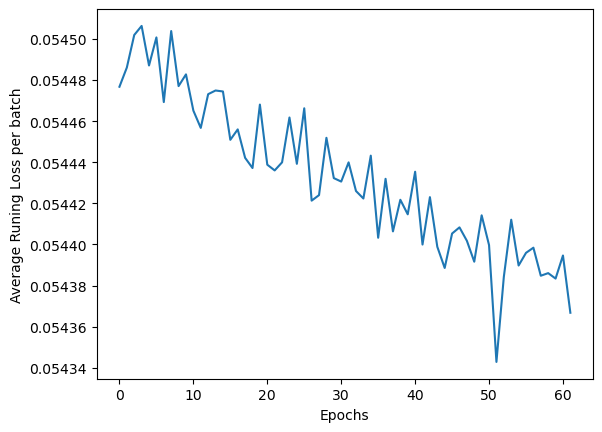

In [22]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [23]:
torch.save(final_model, 'model_100206_8g_03.pt')